In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 140MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 132MB/s]


Test Accuracy:  0.6365775401069519
Test Confusion Matrix: 
 [[12344     4  5630]
 [  375    10   305]
 [ 7265    13 11454]]


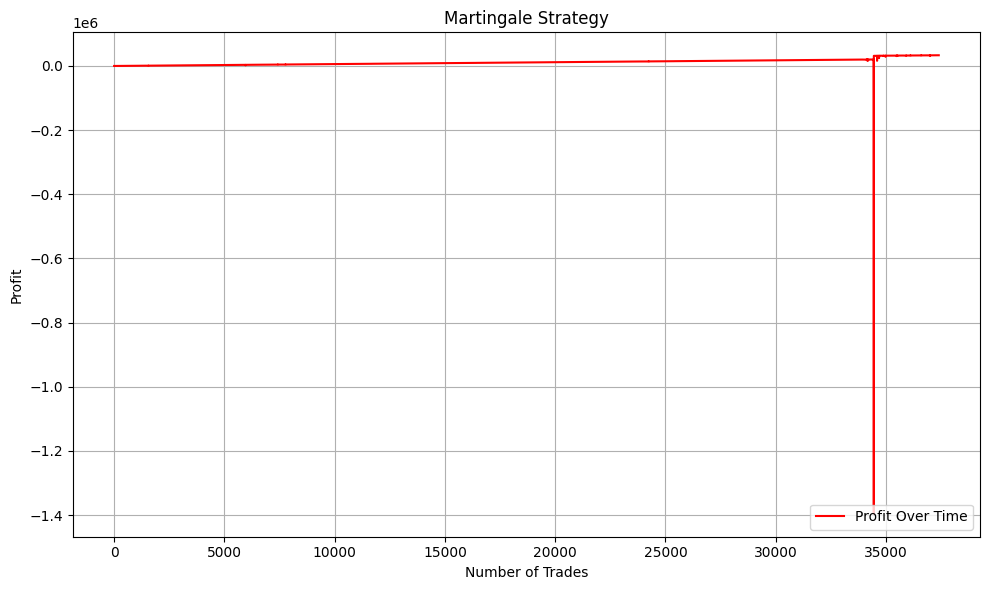

Martingale final profit: 33339.50


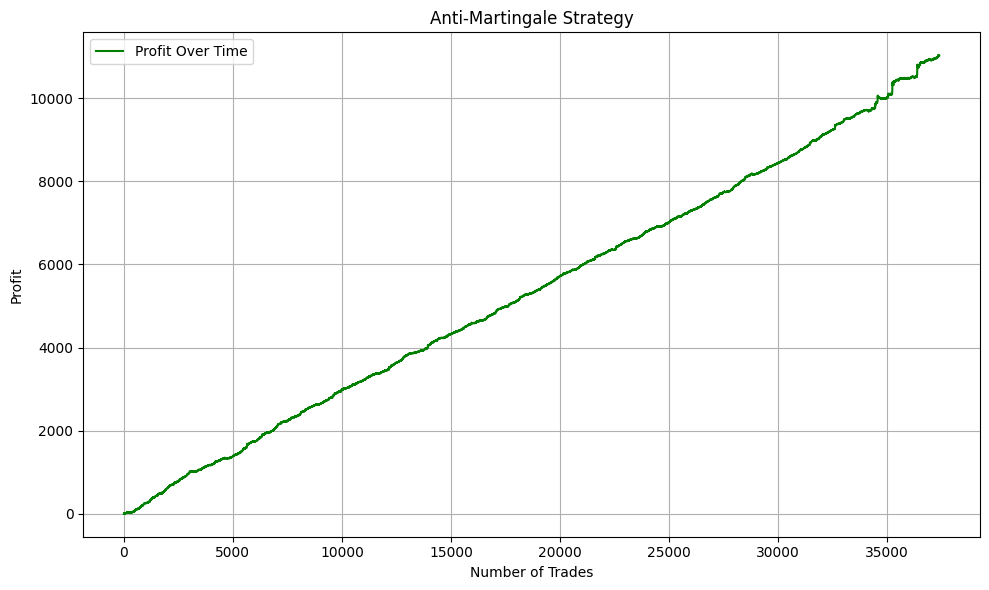

Anti-Martingale final profit: 11019.89
凱利最終本金: 262771478890486916752077560744276552319714197504.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 3
run_analysis(shift_value)


Test Accuracy:  0.5702136763565373
Test Confusion Matrix: 
 [[10626    16  7237]
 [  171     5   204]
 [ 8431    12 10691]]


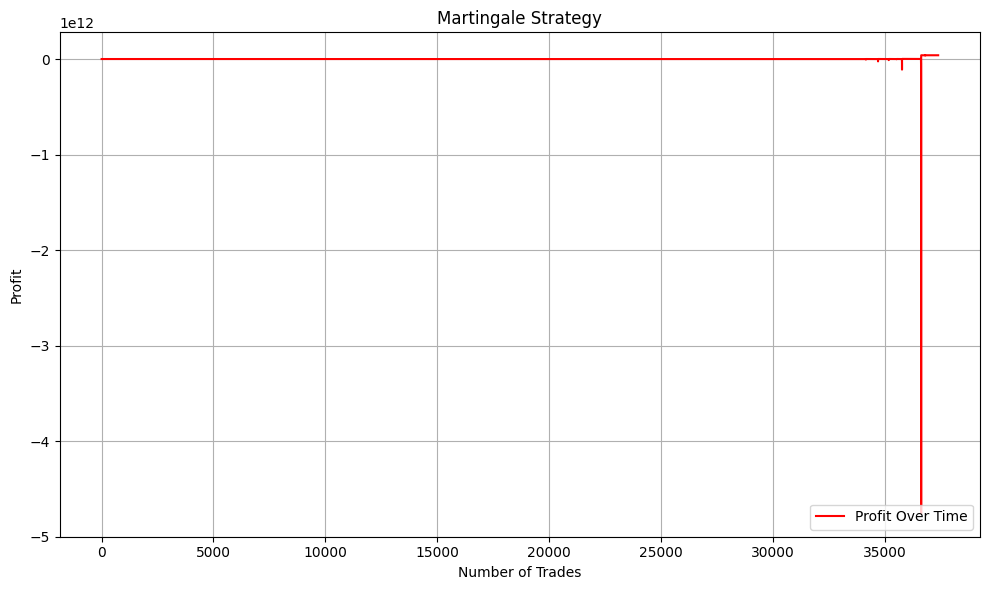

Martingale final profit: 39380441270.67


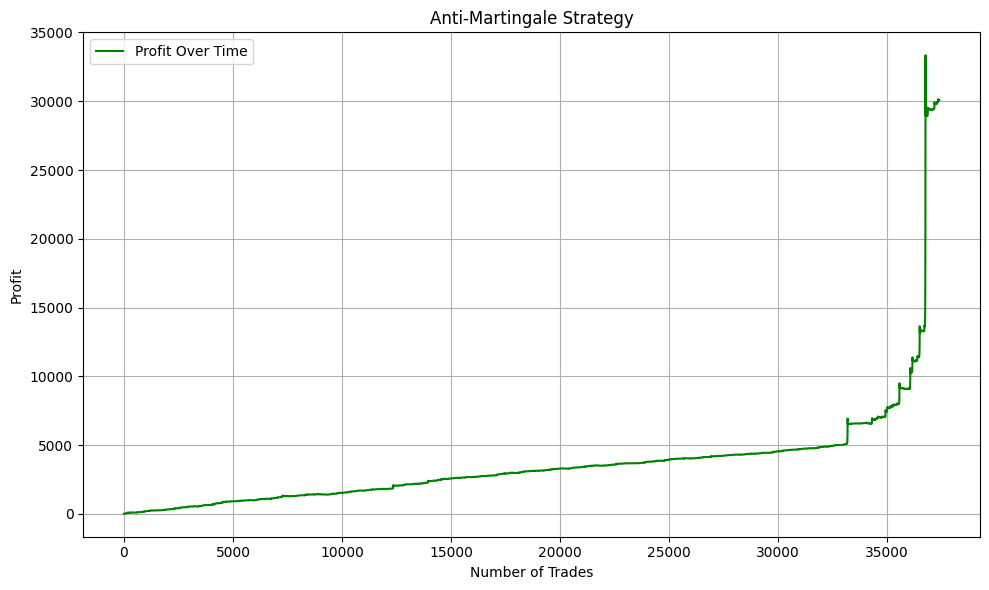

Anti-Martingale final profit: 30076.95
凱利最終本金: 75274100591.02


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 10
run_analysis(shift_value)


Test Accuracy:  0.5428135783644973
Test Confusion Matrix: 
 [[ 9553    19  8229]
 [  101     5   129]
 [ 8599    14 10734]]


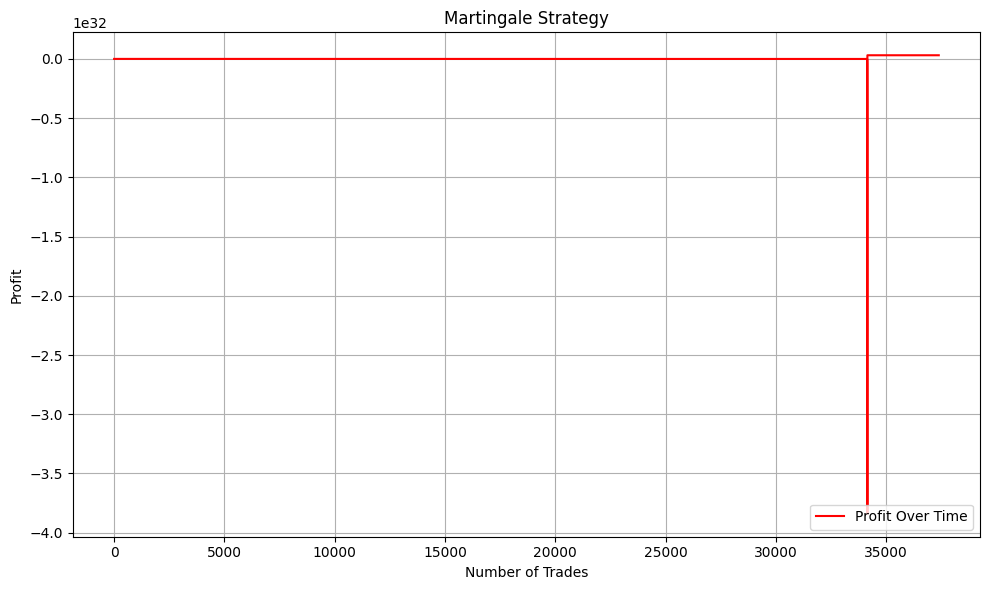

Martingale final profit: 3072260641621789736909685129216.00


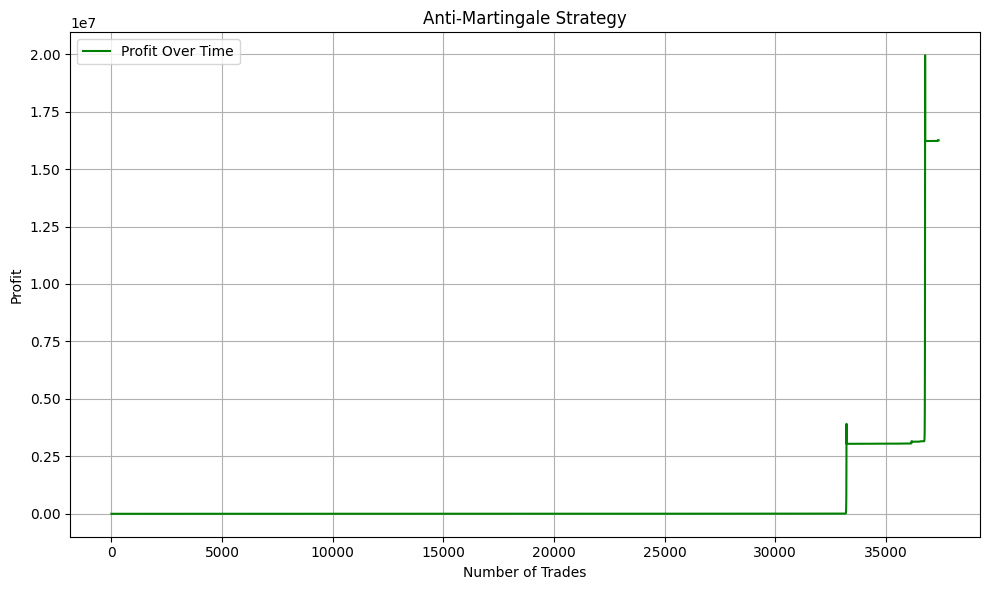

Anti-Martingale final profit: 16249631.60
凱利最終本金: 0.06


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 20
run_analysis(shift_value)


Test Accuracy:  0.5254060417948787
Test Confusion Matrix: 
 [[ 9429   128  8119]
 [   88     6   117]
 [ 9112   173 10201]]


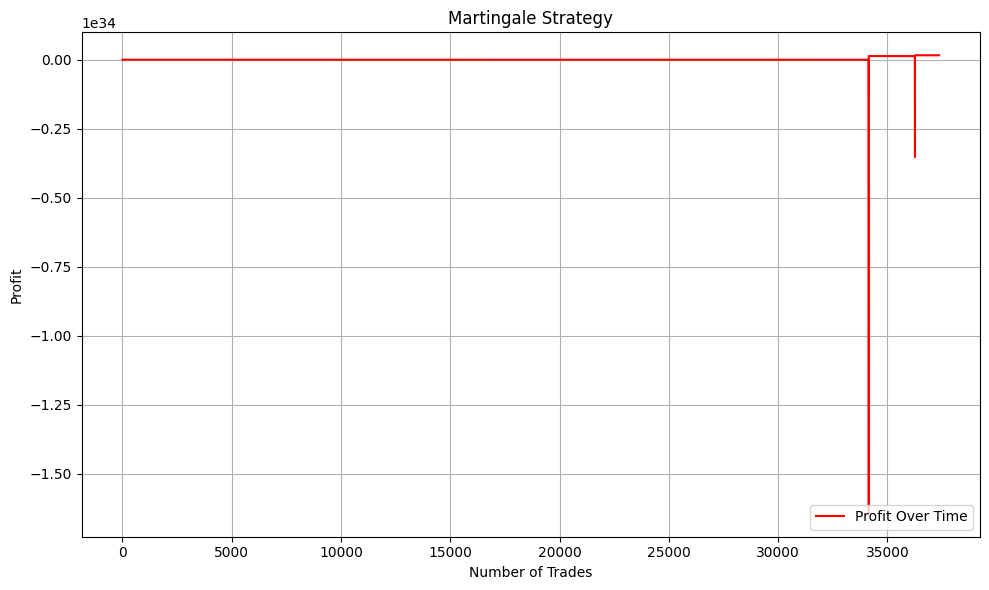

Martingale final profit: 160836981356194455181089208008704.00


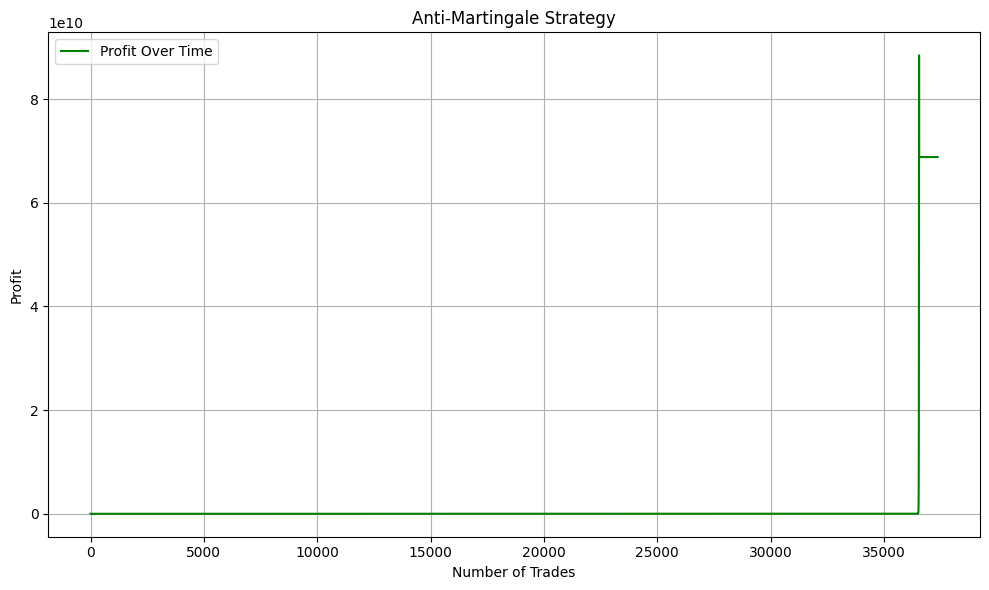

Anti-Martingale final profit: 68826054049.68
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 30
run_analysis(shift_value)


Test Accuracy:  0.5262960683028665
Test Confusion Matrix: 
 [[ 9004    86  8384]
 [   66     6   104]
 [ 8929   130 10654]]


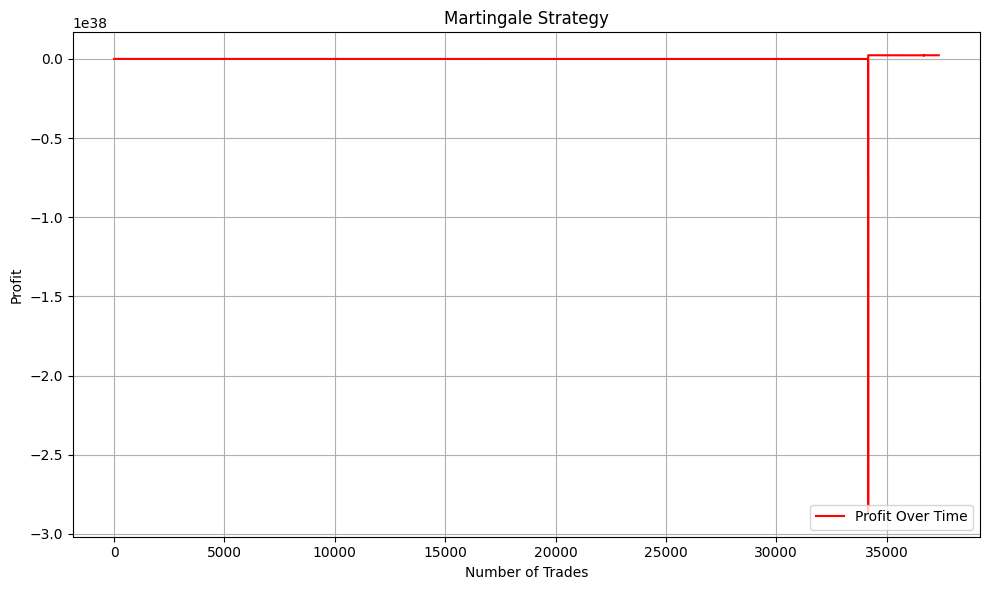

Martingale final profit: 2301470066899652289005735161460948992.00


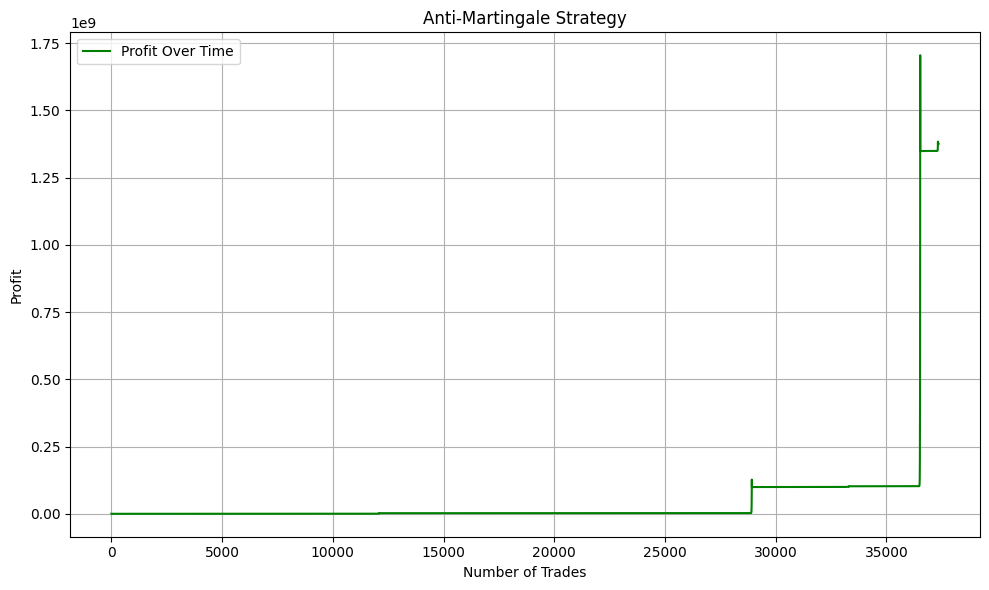

Anti-Martingale final profit: 1375931246.81
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 40
run_analysis(shift_value)


Test Accuracy:  0.5233850025433031
Test Confusion Matrix: 
 [[ 8597    32  8721]
 [   67     7    68]
 [ 8869    46 10946]]


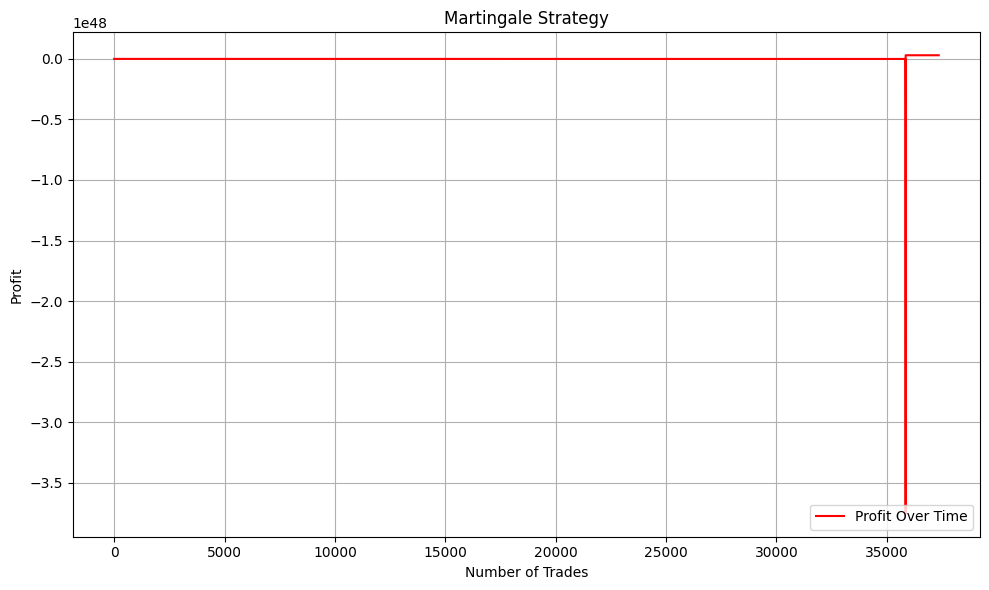

Martingale final profit: 30054896961204085733137973713104591271013384192.00


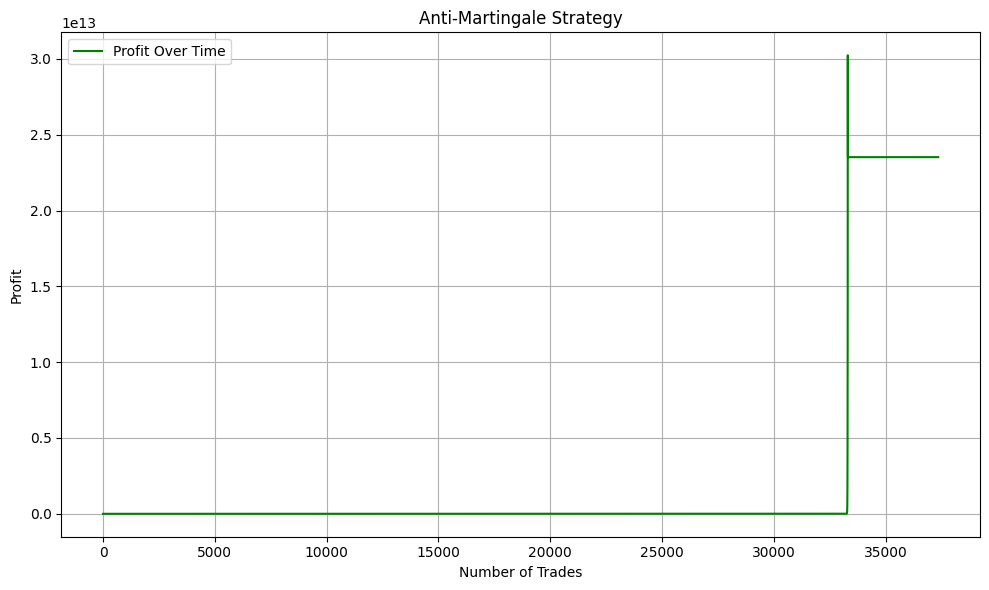

Anti-Martingale final profit: 23521804768837.86
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 50
run_analysis(shift_value)


Test Accuracy:  0.5186781993947995
Test Confusion Matrix: 
 [[ 8655    15  8636]
 [   54     5    76]
 [ 9172    21 10709]]


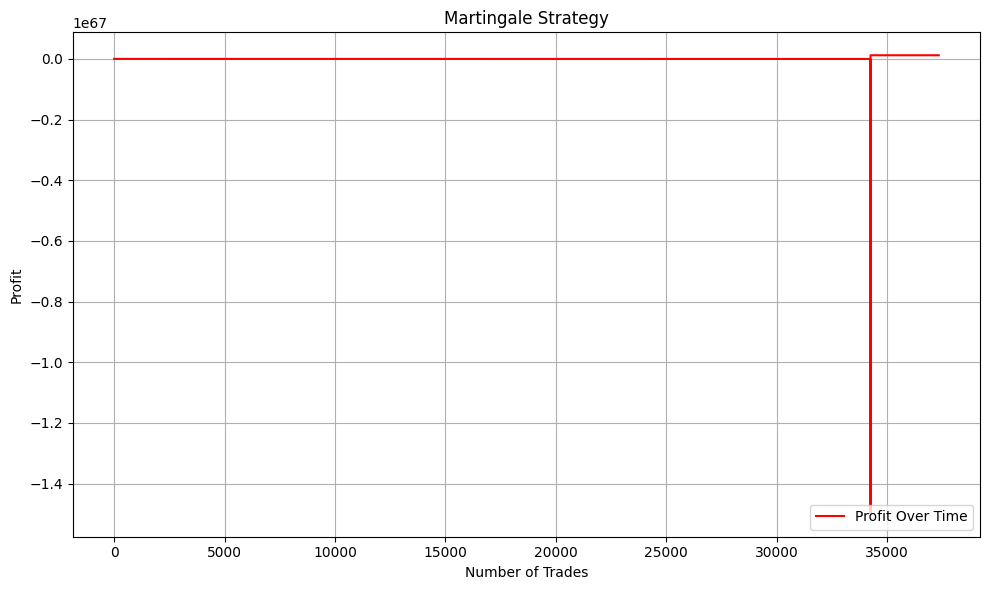

Martingale final profit: 119967841754882994288458310284687194054249469821623641080929976320.00


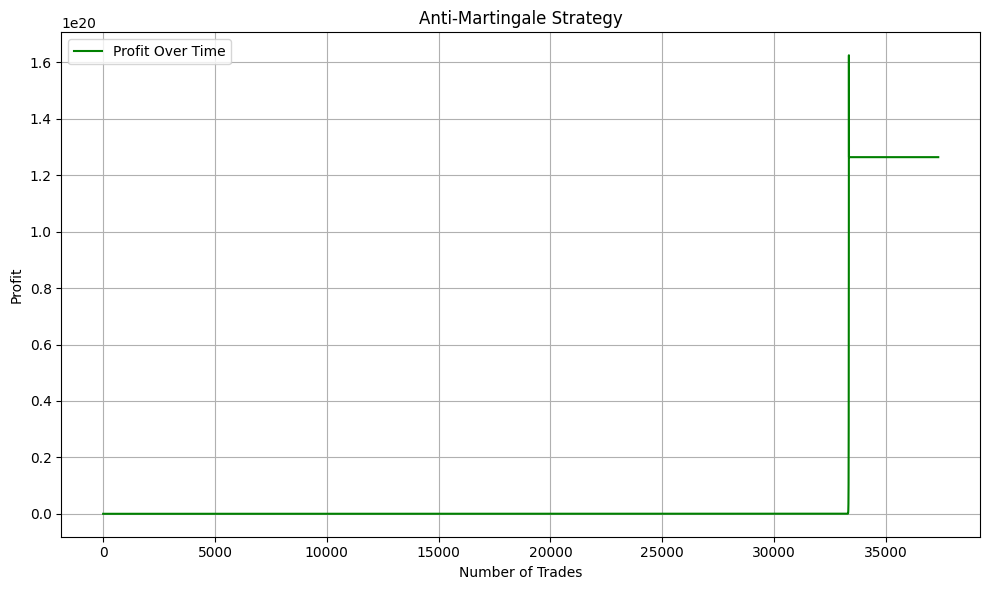

Anti-Martingale final profit: 126425831797323120640.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 60
run_analysis(shift_value)


Test Accuracy:  0.5120296113510179
Test Confusion Matrix: 
 [[ 7768    14  9483]
 [   33     5    62]
 [ 8591    10 11317]]


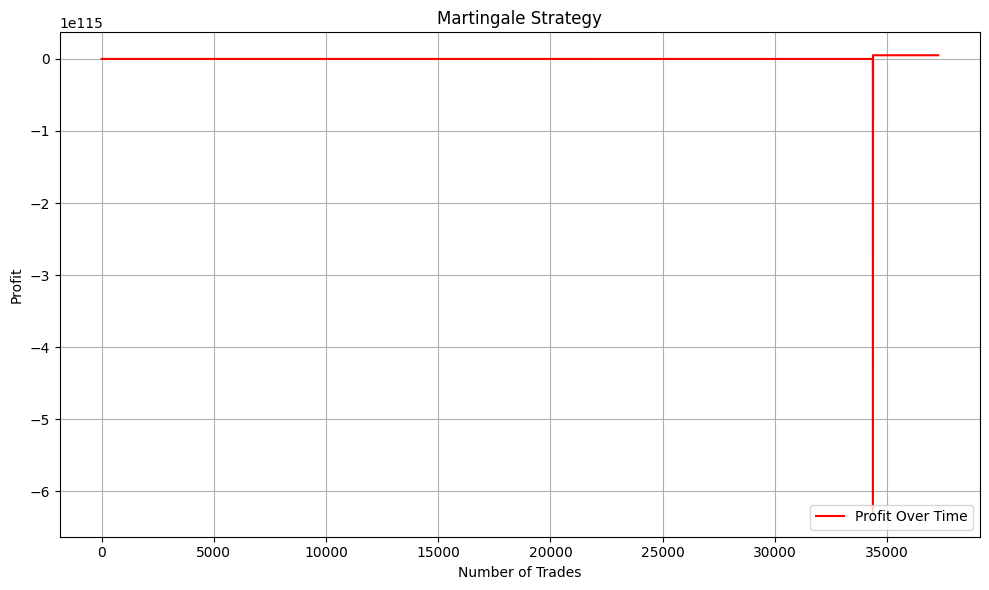

Martingale final profit: 504780528531633855561805784984988795621218819329340510788597952784654200227681667361121384189607223236334012334080.00


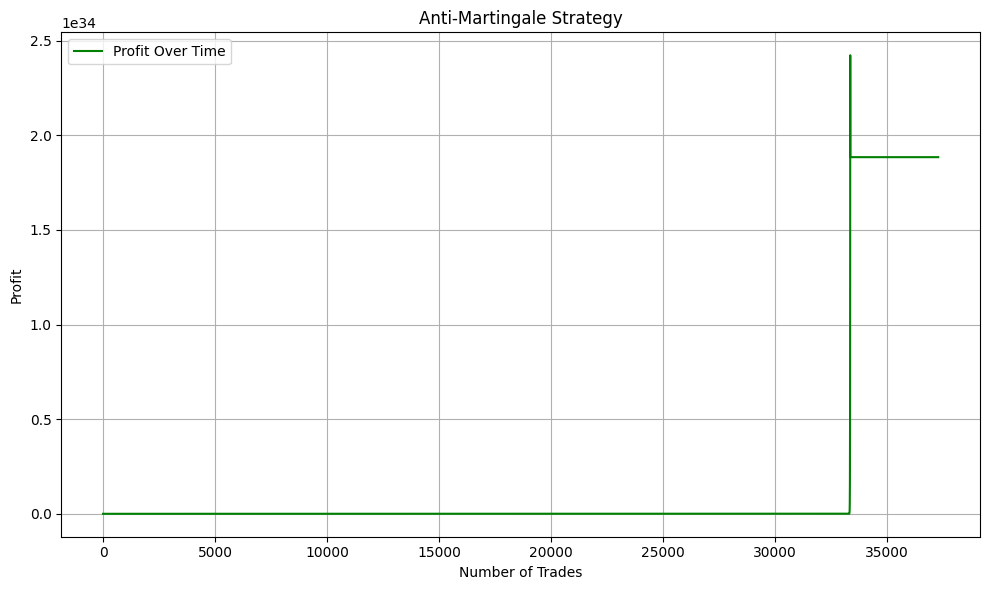

Anti-Martingale final profit: 18848589696184150540251276351897600.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 120
run_analysis(shift_value)


Test Accuracy:  0.46834216828566044
Test Confusion Matrix: 
 [[ 7923    25  9126]
 [   23     5    29]
 [10526    29  9477]]


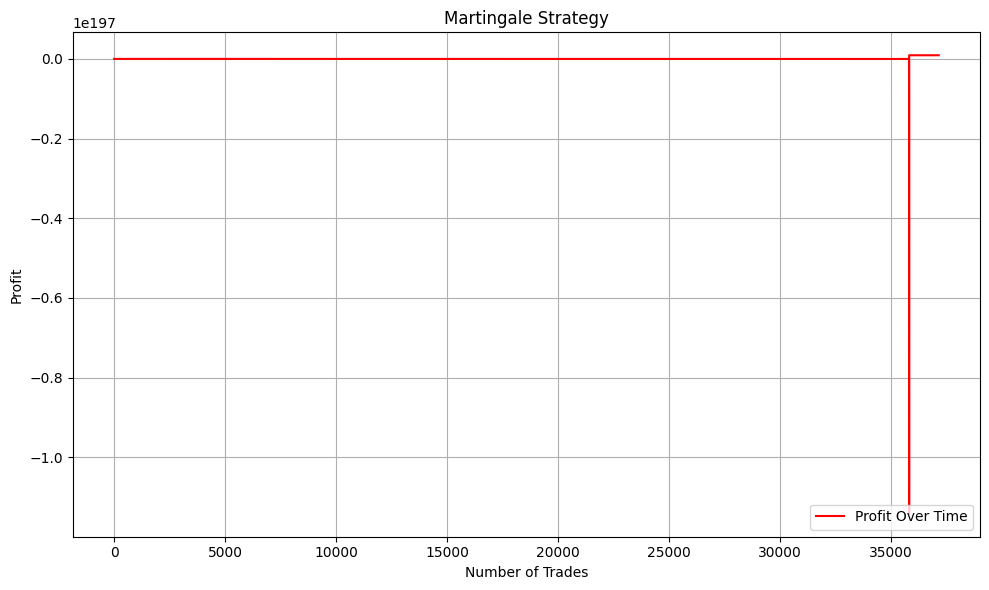

Martingale final profit: 913549249760738534526185299582791665329625288563783340444497984785124562719412510040980429374129326413142808173168589799579918348169352462230294167090931511119601336155134685606300504380432973824.00


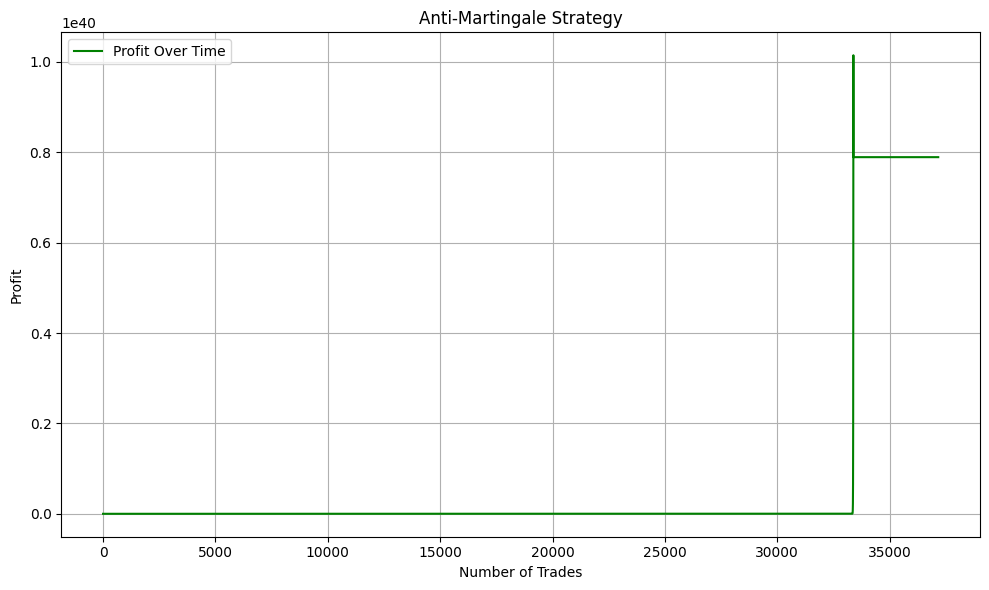

Anti-Martingale final profit: 7891277758493864468689549458781857906688.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 240
run_analysis(shift_value)


Test Accuracy:  0.48254730988310884
Test Confusion Matrix: 
 [[8025    7 9324]
 [  16    5   27]
 [9779   15 9845]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


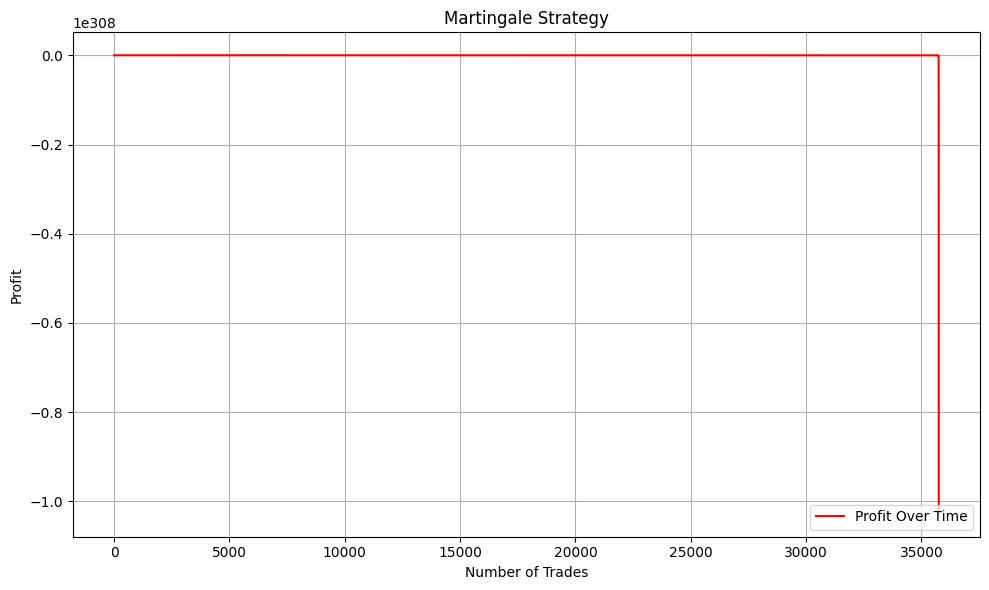

Martingale final profit: nan


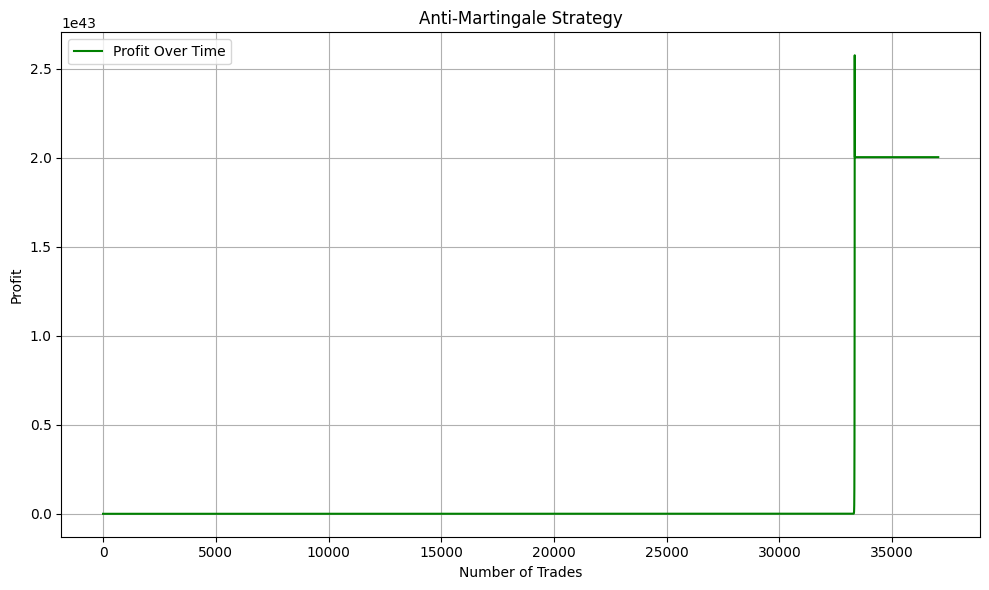

Anti-Martingale final profit: 20043062985287947972292429179377871560376320.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 360
run_analysis(shift_value)


Test Accuracy:  0.4784280800585001
Test Confusion Matrix: 
 [[ 7494    19  9658]
 [   24     5    27]
 [ 9507    23 10166]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


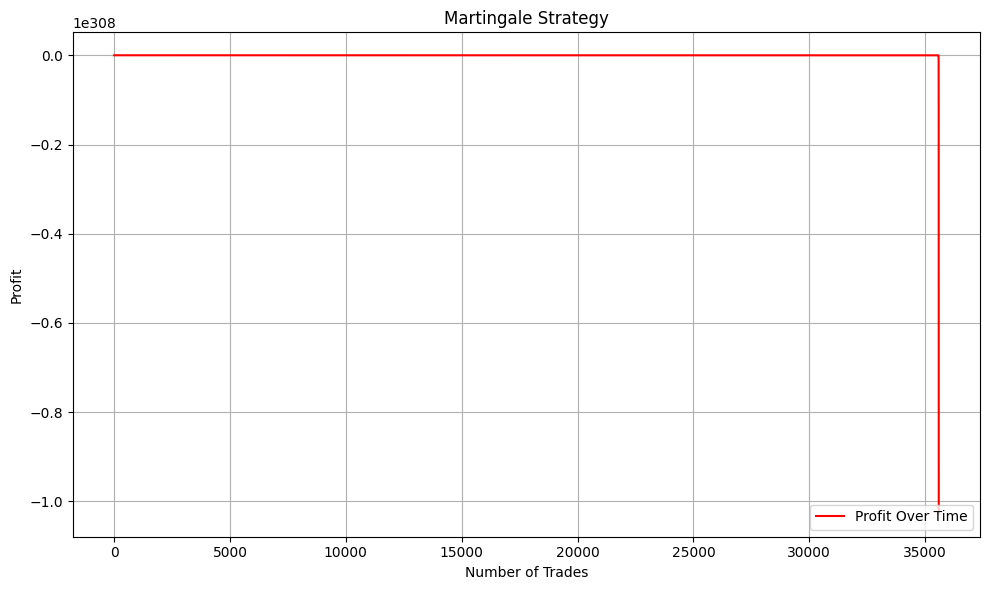

Martingale final profit: nan


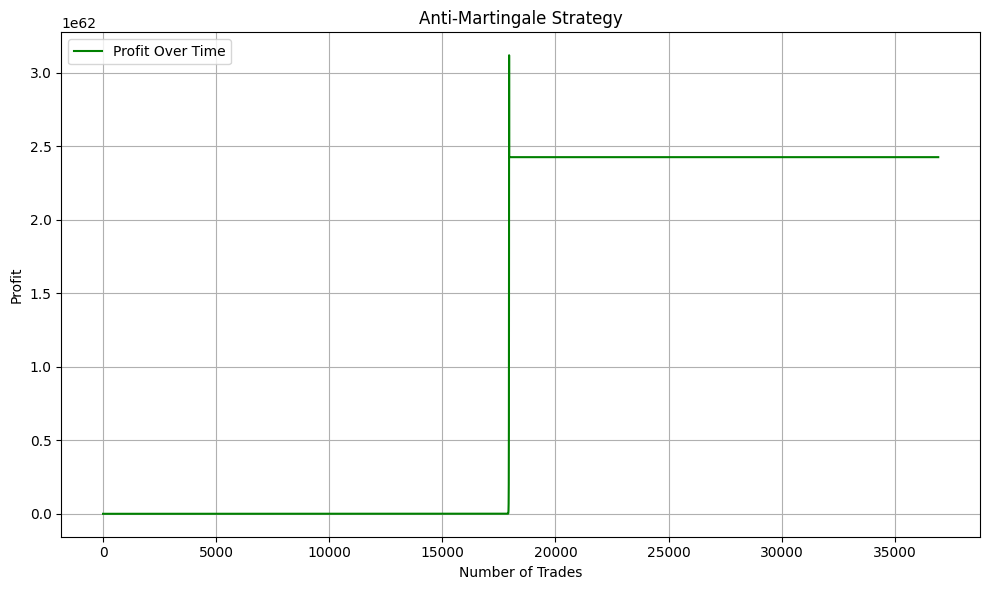

Anti-Martingale final profit: 242449452400540982127412137187379051641071213599317227726700544.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 480
run_analysis(shift_value)


Test Accuracy:  0.46724451810993667
Test Confusion Matrix: 
 [[7283   14 9669]
 [  16    5   23]
 [9875   10 9908]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


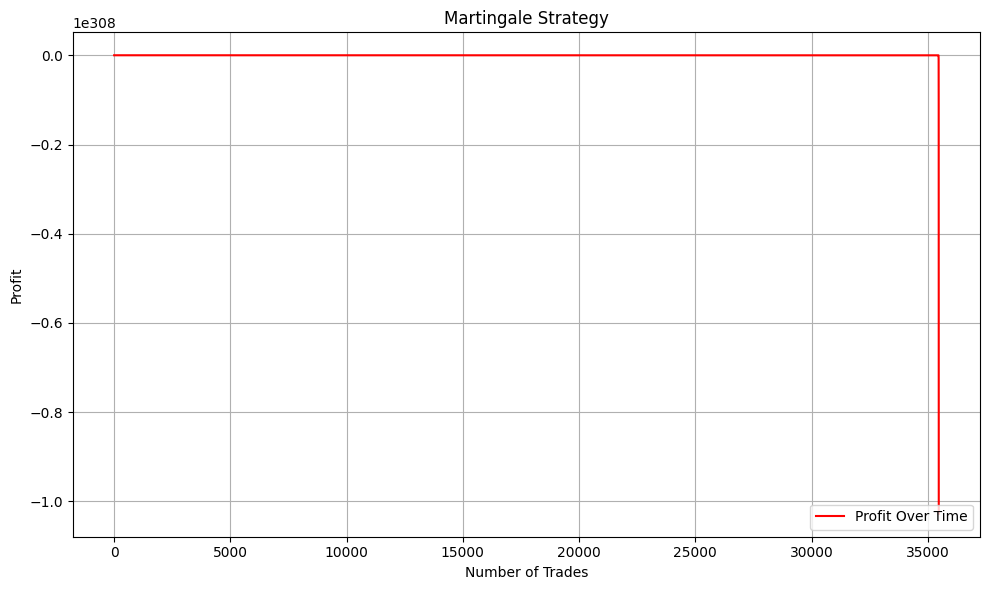

Martingale final profit: nan


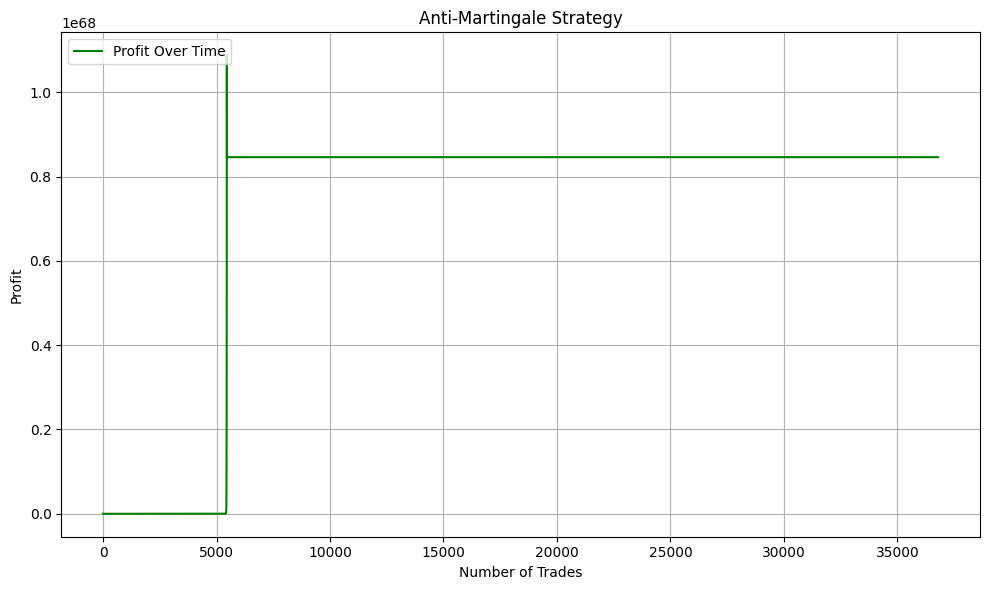

Anti-Martingale final profit: 84587936555976026985752548814640908979231996042869745848128293044224.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 600
run_analysis(shift_value)


Test Accuracy:  0.48305754709265875
Test Confusion Matrix: 
 [[ 7397    12  9272]
 [   25     5     9]
 [ 9626    19 10318]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


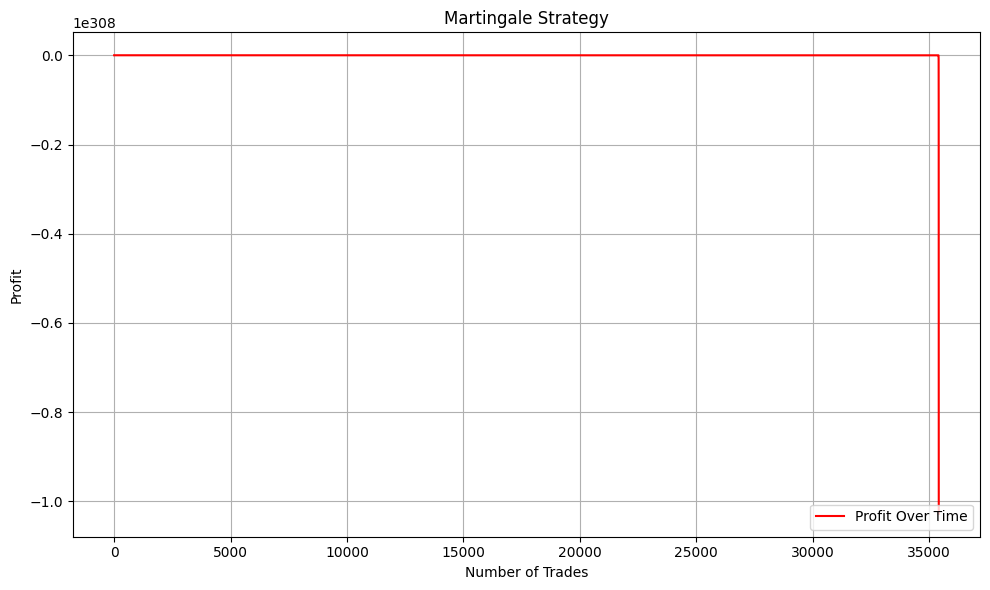

Martingale final profit: nan


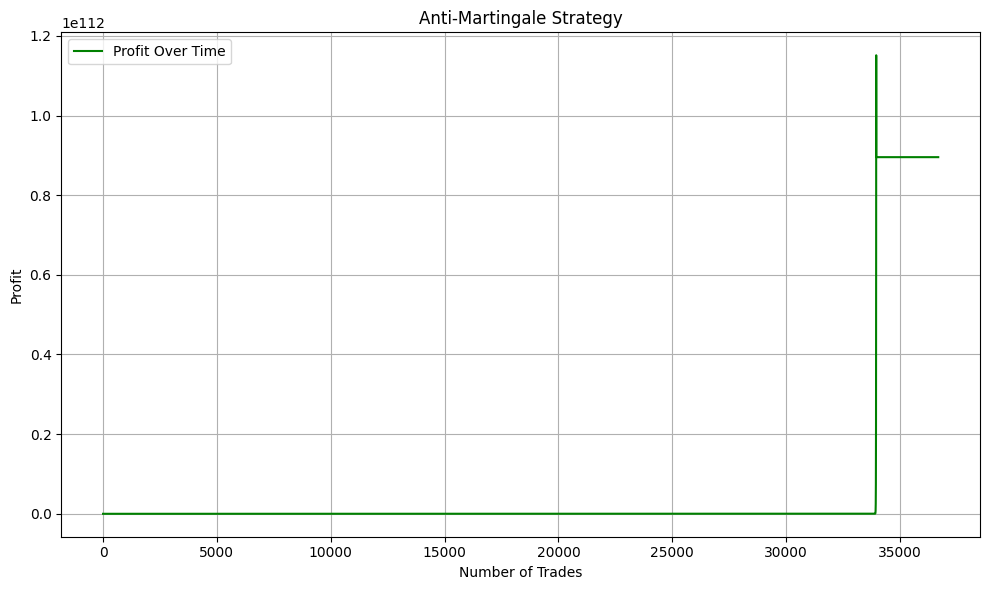

Anti-Martingale final profit: 8955322562560641436226560950673233981466050496045701235742134858645495804650876440829143233126426213647038545920.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 720
run_analysis(shift_value)


Test Accuracy:  0.4814703388671608
Test Confusion Matrix: 
 [[ 6983     5  9302]
 [   20     5    13]
 [ 9601    18 10616]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


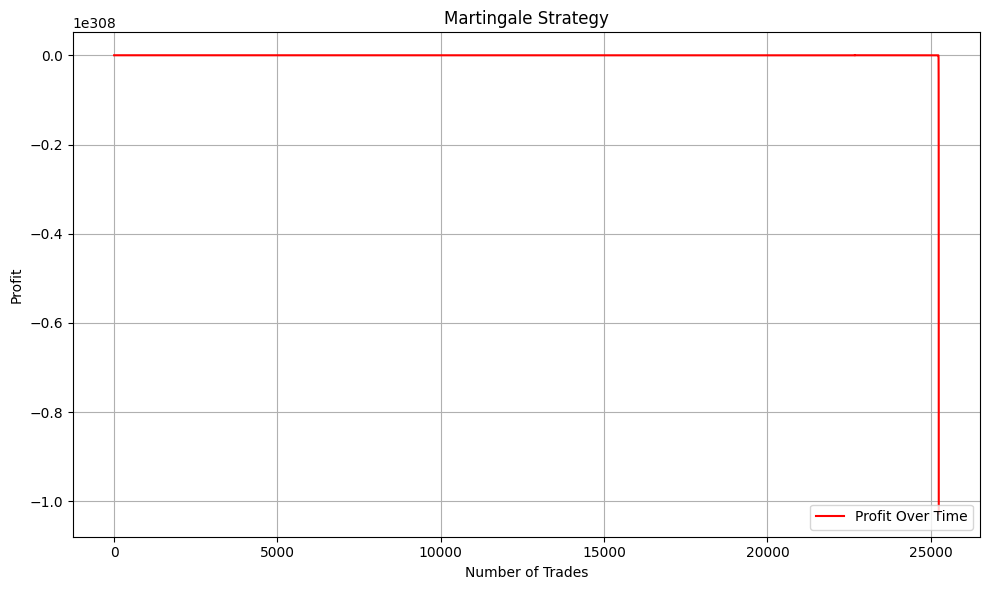

Martingale final profit: nan


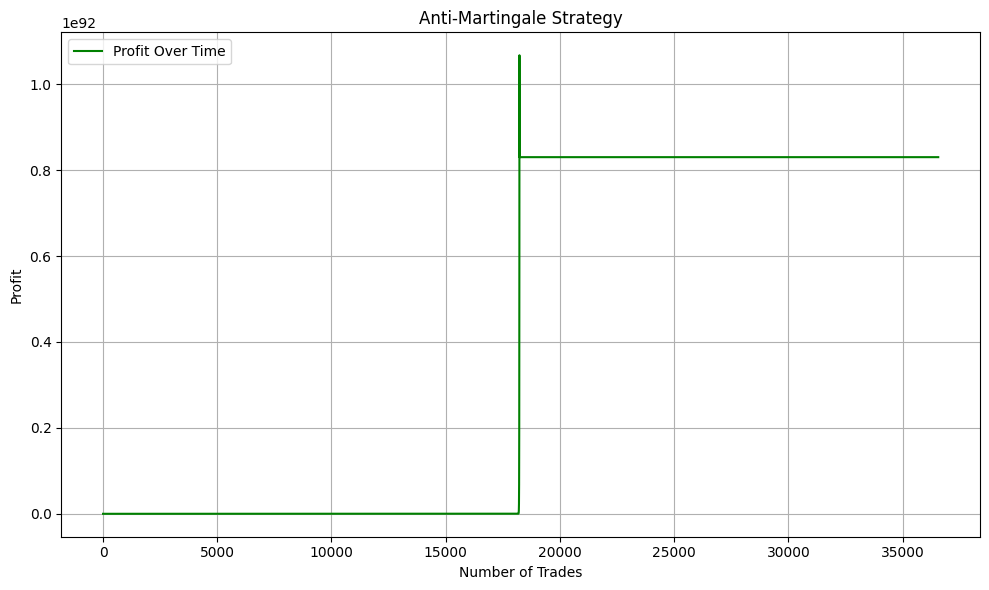

Anti-Martingale final profit: 83028315046038801160130537019812297095018590728283243638666433706302254754174300785616093184.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 840
run_analysis(shift_value)


Test Accuracy:  0.44291084707625605
Test Confusion Matrix: 
 [[ 6361    11  9346]
 [   16     5    13]
 [10788   128  9775]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


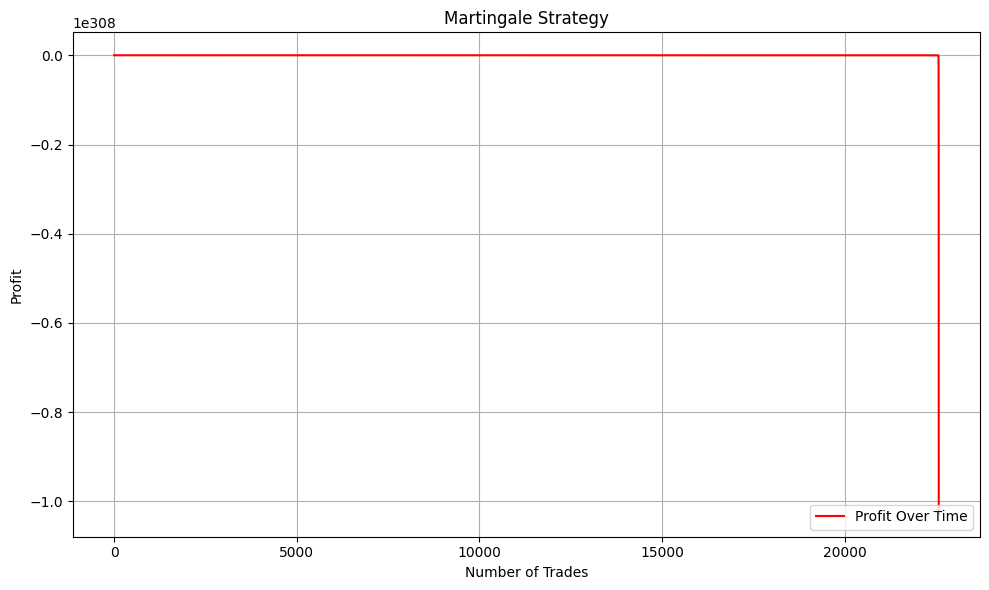

Martingale final profit: nan


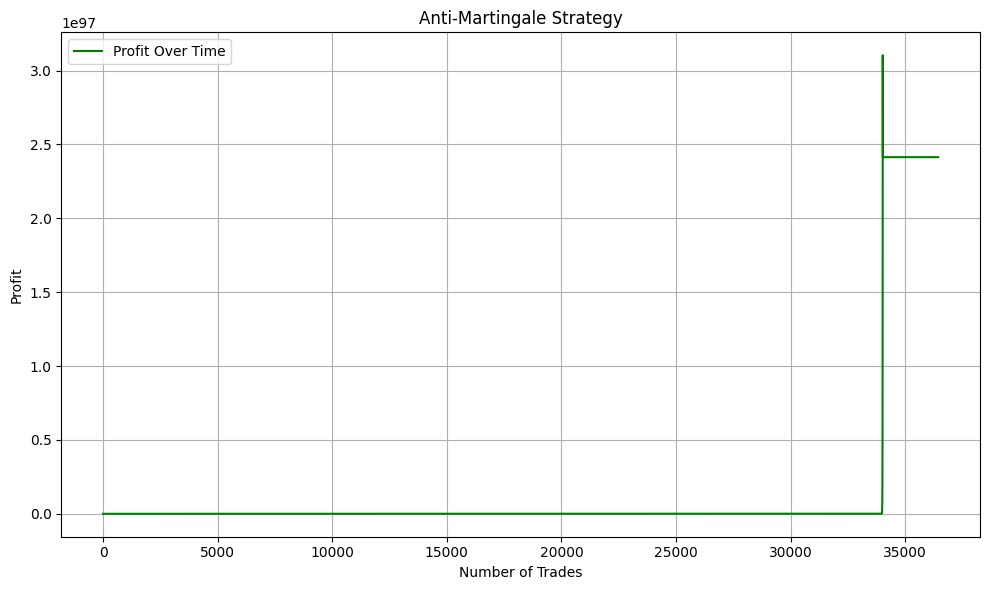

Anti-Martingale final profit: 24139705842608252112415855260897237011180930002310274544069887611397053214542852925700647967260672.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 960
run_analysis(shift_value)


Test Accuracy:  0.40784076205159264
Test Confusion Matrix: 
 [[ 4673     3 10583]
 [   23     5     9]
 [10879    12 10136]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


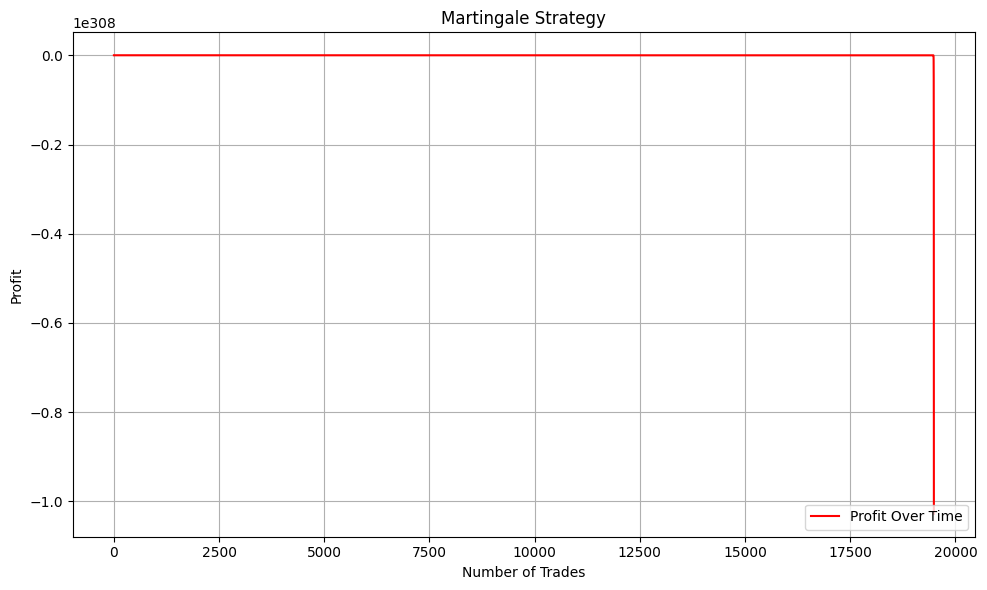

Martingale final profit: nan


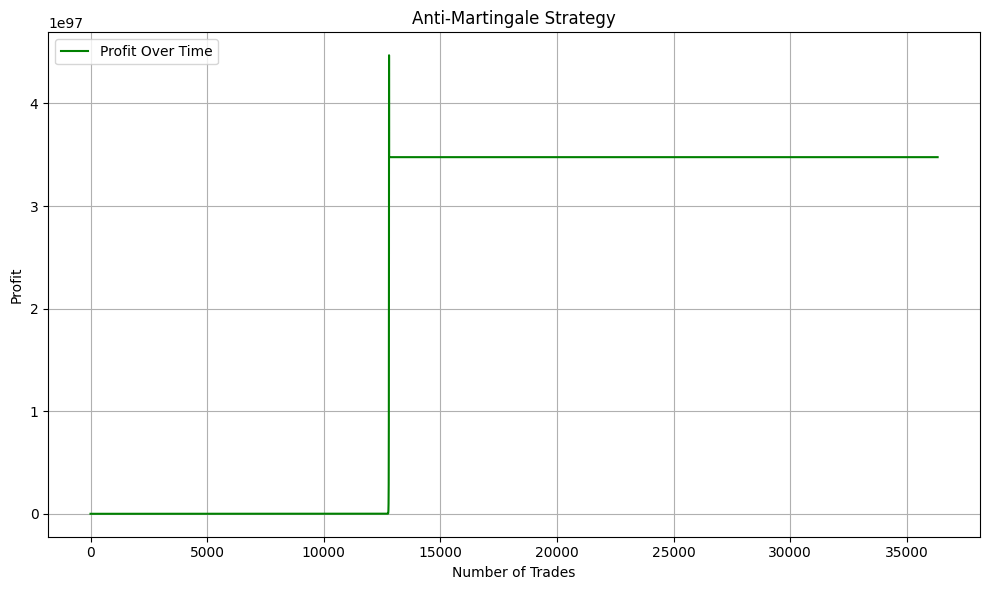

Anti-Martingale final profit: 34761175368933740174585067648954075031648929344414761640681943468575873697723087141417614112194560.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1080
run_analysis(shift_value)


Test Accuracy:  0.4292463255608355
Test Confusion Matrix: 
 [[ 5524     5  9159]
 [   25     5    13]
 [11440    17 10008]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


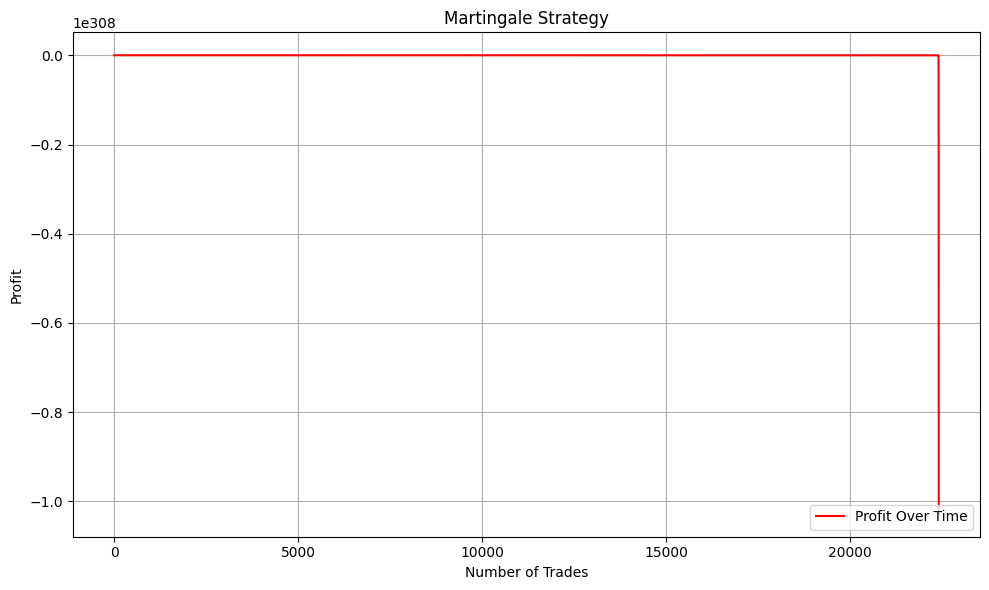

Martingale final profit: nan


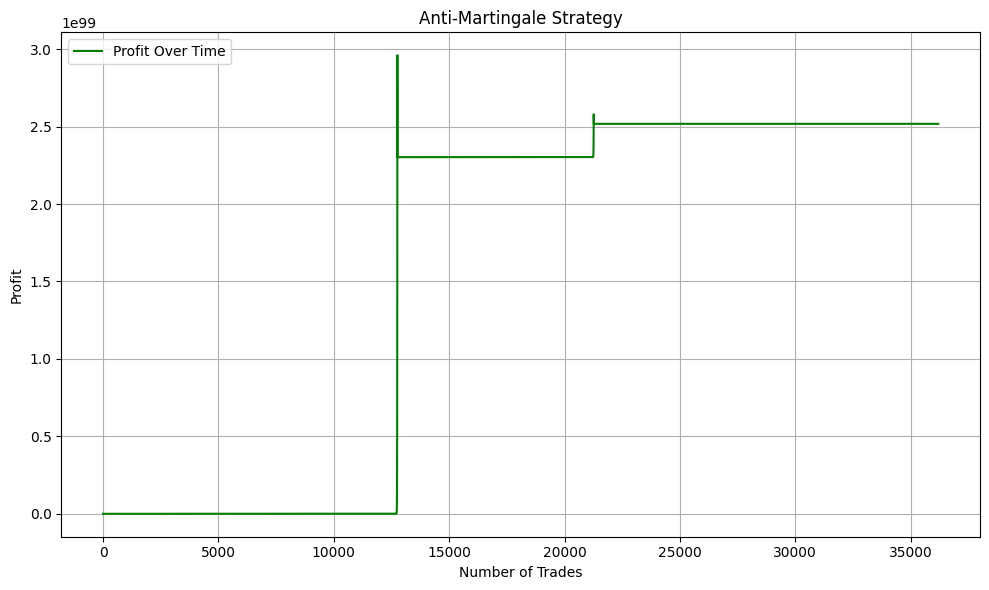

Anti-Martingale final profit: 2518068574780664506159779925571319793908263429601303850613426890591545312207616101383925507748265984.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1200
run_analysis(shift_value)


Test Accuracy:  0.45826863354037267
Test Confusion Matrix: 
 [[ 6380     7  8167]
 [   17     5     9]
 [11309    28 10142]]


/usr/local/lib/python3.10/dist-packages/matplotlib/ticker.py:2094: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


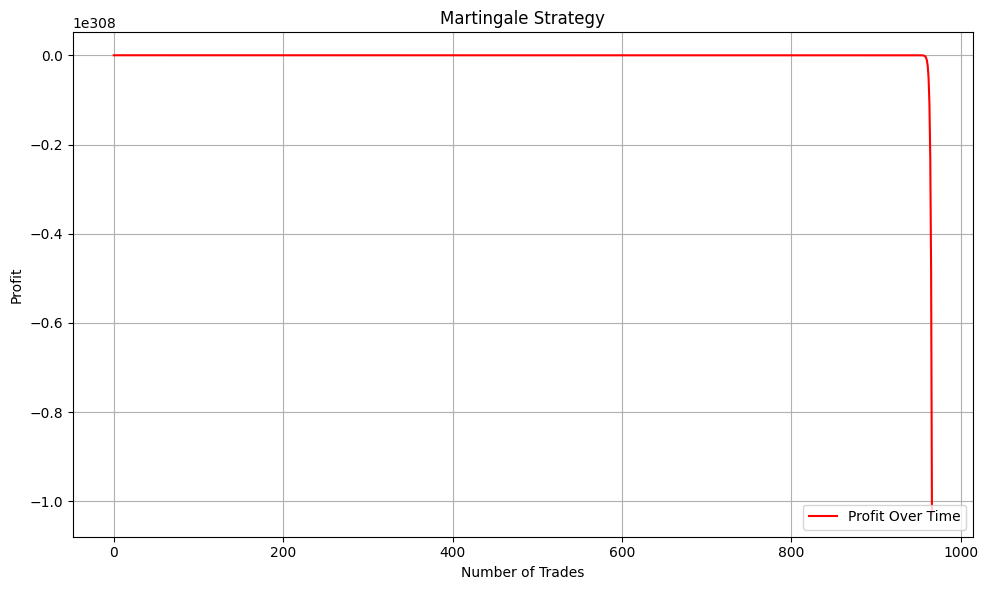

Martingale final profit: nan


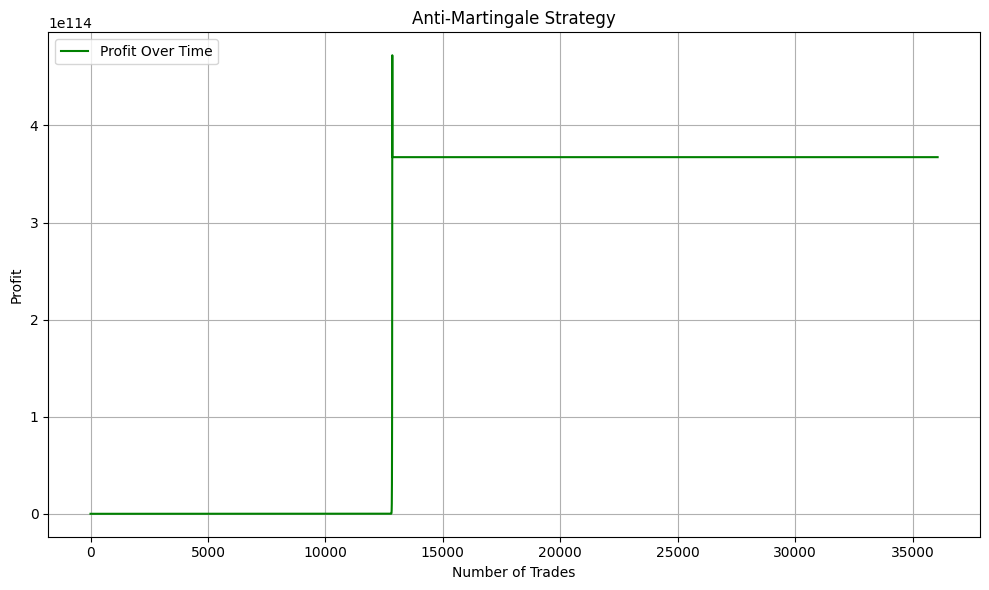

Anti-Martingale final profit: 3673350360786645779574140098025881735438075326012154346544008737701785914697779565904954379659485452332546167668736.00
凱利最終本金: 0.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

def run_analysis(shift_value):
    # 資料合併
    data = pd.merge(data_bid, data_ask, on='Local time', how='left')

    # 填充NaN值
    data.fillna(0, inplace=True)

    # 計算平均價格和總交易量
    data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
    data['Average_High'] = (data['High_x'] + data['High_y']) / 2
    data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
    data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
    data['Total_Volume'] = data['Volume_x'] + data['Volume_y']

    # 刪除不需要的列
    columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
    data.drop(columns=columns_to_drop, inplace=True)

    # 計算價格變動和交易量變動
    data['Price_Change'] = data['Average_Close'].pct_change()
    data['Volume_Change'] = data['Total_Volume'].pct_change()

    # 基於設定的shift值創建未來收盤價字段
    data['Future_Close'] = data['Average_Close'].shift(-shift_value)
    data['Duration_Change'] = data['Future_Close'] - data['Average_Open']

    # 處理缺失值
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    # 轉換日期時間特徵
    data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.%f GMT%z', dayfirst=True)
    # 類別標籤化
    data['Label'] = data['Duration_Change'].apply(lambda x: 2 if x > 0 else 0 if x < 0 else 1)
    # 分割訓練集和測試集
    train_size = int(len(data) * 0.9)  # 計算訓練集的大小
    train_data = data.iloc[:train_size]  # 分割訓練集
    test_data = data.iloc[train_size:]  # 分割測試集

    # 從訓練集和測試集中移除最後shift_value條數據
    train_data = train_data[:-shift_value]
    test_data = test_data[:-shift_value]

    # 添加時間循環特徵
    for df in [train_data, test_data]:
        df['DayOfWeek'] = df['Local time'].dt.weekday
        df['Hour'] = df['Local time'].dt.hour
        df['DayOfWeekSin'] = np.sin(df['DayOfWeek'] * (2 * np.pi / 7))
        df['DayOfWeekCos'] = np.cos(df['DayOfWeek'] * (2 * np.pi / 7))
        df['HourSin'] = np.sin(df['Hour'] * (2 * np.pi / 24))
        df['HourCos'] = np.cos(df['Hour'] * (2 * np.pi / 24))

    # 定義特徵列表
    features = [
        "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
        "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
    ]

    # 準備訓練和測試資料
    x_train = train_data[features].fillna(train_data.mean())
    y_train = train_data['Label']
    x_test = test_data[features].fillna(train_data.mean())
    y_test = test_data['Label']

    # 資料正規化
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    best_model = GradientBoostingClassifier(
        subsample=0.75,
        n_estimators=50,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=5,
        learning_rate=0.1,
        random_state=0
    )

    # 訓練模型
    best_model.fit(x_train, y_train)

    # 使用測試集預測
    y_pred = best_model.predict(x_test)

    # 輸出預測結果的評估指標
    print('Test Accuracy: ', accuracy_score(y_test, y_pred))
    print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_pred))

    # 馬丁格爾策略
    def martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet = 1
            else:
                balance -= bet
                bet *= 2.12
            balances.append(balance)

        return balances

    predictions = best_model.predict(x_test)
    balances = martingale_strategy(predictions, y_test)
    martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="red")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Martingale Strategy")
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    print(f"Martingale final profit: {martingale_final_profit:.2f}")

    # 反馬丁格爾策略
    def anti_martingale_strategy(predictions, true_values):
        balances = []
        balance = 0
        bet = 1

        for i, (pred, true) in enumerate(zip(predictions, true_values)):
            if pred == true:
                balance += 0.9 * bet
                bet *= 1.2  # 增加投注量
            else:
                balance -= bet
                bet = 1  # 恢復原始投注量或可以選擇減少投注量
            balances.append(balance)

        return balances

    balances = anti_martingale_strategy(predictions, y_test)
    anti_martingale_final_profit = balances[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(balances, label="Profit Over Time", color="green")
    plt.xlabel("Number of Trades")
    plt.ylabel("Profit")
    plt.title("Anti-Martingale Strategy")
    plt.grid(True)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()
    print(f"Anti-Martingale final profit: {anti_martingale_final_profit:.2f}")

    # 凱利策略
    probabilities = best_model.predict_proba(x_test)
    capital = 1000
    max_trades = 2000

    for i, (proba, actual) in enumerate(zip(probabilities, y_test)):
        if i >= max_trades:
            break
        pred = np.argmax(proba)
        max_proba = np.max(proba)

        b = 0.9
        p = max_proba
        q = 1 - p
        f_star = (b * p - q) / b if (b * p - q) / b > 0 else 0

        bet_amount = capital * f_star

        if pred == actual:
            if pred == 1:
                capital -= bet_amount
            else:
                capital += bet_amount * b
        else:
            capital -= bet_amount

    print(f"凱利最終本金: {capital:.2f}")

# 修改shift_value
shift_value = 1320
run_analysis(shift_value)
